<a href="https://colab.research.google.com/github/andreyxz2000/Test/blob/main/Copy_of_%D0%92%D0%B5%D0%B1%D0%B8%D0%BD%D0%B0%D1%80_Terra_AI_Datasets_11_%D0%B0%D0%BF%D1%80%D0%B5%D0%BB%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip download terra-ai-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
!pip freeze > requirements.txt

In [ ]:
# @title Подключение библиотек
%%capture
!pip install terra-ai-datasets

import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.utils import load_img, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv1D, Flatten, Dropout, BatchNormalization, Input, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tqdm.notebook import tqdm


def visualize_dataset_shapes(dataset):
    for split in ["train", "val"]:
        print(f'\n--- Выборка {split} ---')
        for i, (inp, arr) in enumerate(dataset.X[split].items(), 1):
            print(f'Вход {i}: {arr.shape}')
        for i, (inp, arr) in enumerate(dataset.Y[split].items(), 1):
            print(f'Выход {i}: {arr.shape}')


# БЛОК КЛАССИФИКАЦИИ ИЗОБРАЖЕНИЙ
def load_image_classification_data():
    !curl -L -s -o /content/cars.zip 'https://storage.yandexcloud.net/terraai/sources/cars.zip'
    !unzip cars.zip -d /content/cars


def visualize_img_cls_prediction(dataset, model, num_samples=5, network="Convolutional"):
    classes_names = dataset.put_instructions[2]['2_Classification'].parameters.classes_names

    inp, out, pred = next(dataset.evaluate_on_model(model, batch_size=num_samples))  # Возьмем первые 5 примеров из валидационной выборки

    y_val = np.argmax(out['output_1'].numpy(), axis=1)                                       # Использовали One-Hot Encoding
    y_pred = np.argmax(pred, axis=1)                                                         # Использовали One-Hot Encoding

    classes_names = dataset.put_instructions[2]['2_Classification'].parameters.classes_names

    if network == "Linear":
        for i, (y_t, y_p) in enumerate(zip(y_val, y_pred)):
            print(f"Пример {i}: Истина: {y_t}, Предсказание: {y_p}")
    else:
        fig, ax = plt.subplots(1, num_samples, figsize=(num_samples*3,5))
        for i, (x, y_t, y_p) in enumerate(zip(inp['input_1'], y_val, y_pred)):
            ax[i].imshow(x)
            ax[i].set_title(f"{classes_names[y_p]} ({classes_names[y_t]})")


# БЛОК КЛАССИФИКАЦИИ ТЕКСТОВ
def load_text_classification_data():
    !curl -L -s -o /content/writers.zip 'https://storage.yandexcloud.net/terraai/sources/writers.zip'
    !unzip writers.zip -d /content/writers


def most_common_words(dataset, words_count):
    index_word = dataset.preprocessing['1_Text'].index_word
    pairs = {k: index_word[k] for k in list(index_word)[:words_count]}
    return pairs


def visualize_txt_cls_prediction(dataset, model, num_samples=10, dataset_type="Embedding"):

    classes_names = dataset.put_instructions[2]['2_Classification'].parameters.classes_names
    inp, out, pred = next(dataset.evaluate_on_model(model, batch_size=num_samples))

    y_val = np.argmax(out['output_1'].numpy(), axis=1)
    y_pred = np.argmax(pred, axis=1)

    for i, (sample, y_t, y_p) in enumerate(zip(inp["input_1"], y_val, y_pred)):
        text_to_output = f'Правда: {classes_names[y_t]}, Предсказание: {classes_names[y_p]}'
        if dataset_type == "Embedding":
            index_word = dataset.preprocessing['1_Text'].index_word
            sample_text = [index_word[s] if s > 0 else "" for s in sample.numpy()]
            text_to_output += f"Вход: {' '.join(sample_text[:8])} ..."
        print(text_to_output)


# БЛОК ВРЕМЕННЫХ РЯДОВ
def load_timeseries_data():
    !curl -L -s -o /content/shares.zip 'https://storage.yandexcloud.net/terraai/sources/shares.zip'
    !unzip shares.zip -d /content/shares


def plot_ts_depth_graph(dataset, sample_idx):
    plt.figure(figsize=(15, 5))
    plt.plot(dataset.X["train"]["input_1"][sample_idx, :, 0], label="<OPEN> (inp)")
    plt.plot(dataset.X["train"]["input_1"][sample_idx, :, 1], label="<HIGH> (inp)")
    plt.plot(dataset.X["train"]["input_1"][sample_idx, :, 2], label="<LOW> (inp)")
    plt.plot(dataset.X["train"]["input_1"][sample_idx, :, 3], label="<CLOSE> (inp)")
    plt.plot([None for _ in range(100)] + dataset.Y["train"]["output_1"][sample_idx, :, 0].tolist(), label="<CLOSE> (out)")
    plt.grid(True, alpha=0.3)
    plt.legend()


def visualize_ts_depth_prediction(dataset, model):
    inp, out, pred = next(dataset.evaluate_on_model(model, batch_size=1))  # Возьмем 1 предсказание

    true = out['output_1'].numpy().flatten()
    prediction = pred.flatten()

    plt.figure(figsize=(15, 5))
    plt.plot(inp['input_1'][0][:, 0], label="<OPEN> (inp)")
    plt.plot(inp['input_1'][0][:, 1], label="<HIGH> (inp)")
    plt.plot(inp['input_1'][0][:, 2], label="<LOW> (inp)")
    plt.plot(inp['input_1'][0][:, 3], label="<CLOSE> (inp)")
        
    plt.plot([None for _ in range(100)] + true.tolist(), label="<CLOSE> (true)")
    plt.plot([None for _ in range(100)] + prediction.tolist(),  linestyle="--", label="<CLOSE> (prediction)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def visualize_ts_trend_prediction(dataset, model):
    classes_names = dataset.put_instructions[2]['5_<CLOSE>'].parameters.classes_names
    inp, out, pred = next(dataset.evaluate_on_model(model, batch_size=10))  # Возьмем первые 10 примеров из валидационной выборки

    true = out['output_1'].numpy().flatten()
    prediction = np.argmax(pred, axis=1)
    for t, p in zip(true, prediction):
        print(f'Истина: {classes_names[t]}, Предсказание: {classes_names[p]}')

# **Terra AI Datasets**

Это фреймворк, позволяющий создавать датасеты для обучения нейросетей, имеющий под капотом множество готовых методов обработки данных для решения целого ряда задач:
* классификация изображений;
* классификация тексов;
* классификация аудио;
* сегментация изображений;
* классификация табличных данных;
* регрессия табличных данных;
* предсказание временных рядов;
* предсказание тренда временных рядов.

Для начала процесса создания датасета нужно инициализировать соответствующий решаемой задаче экземпляр класса.

Не бойтесь ввести неправильные значения - при вводе некорректных значений появится ошибка с указанием неправильного значения, и какие значения допустимы.

В данном уроке рассмотрим применение фреймворка для решения задач классификации изображений, классификации текстов, а также предсказания временных рядов.

In [ ]:
# @title Список поддерживаемых задач

from terra_ai_datasets.create import (
    ImageClassification,
    TextClassification,
    AudioClassification,
    ImageSegmentation,
    DataframeClassification,
    DataframeRegression,
    TimeseriesDepth,
    TimeseriesTrend
)

# Классификация изображений

In [ ]:
# Загрузка и распаковка датасета
load_image_classification_data()

Archive:  cars.zip
  inflating: /content/cars/cars.csv  
  inflating: /content/cars/Феррари/car_Ferrari__1124.png  
  inflating: /content/cars/Феррари/car_Ferrari__1095.png  
  inflating: /content/cars/Феррари/car_Ferrari__989.png  
  inflating: /content/cars/Феррари/car_Ferrari__528.png  
  inflating: /content/cars/Феррари/car_Ferrari__580.png  
  inflating: /content/cars/Феррари/car_Ferrari__575.png  
  inflating: /content/cars/Феррари/car_Ferrari__417.png  
  inflating: /content/cars/Феррари/car_Ferrari__780.png  
  inflating: /content/cars/Феррари/car_Ferrari__1257.png  
  inflating: /content/cars/Феррари/car_Ferrari__470.png  
  inflating: /content/cars/Феррари/car_Ferrari__407.png  
  inflating: /content/cars/Феррари/car_Ferrari__355.png  
  inflating: /content/cars/Феррари/car_Ferrari__547.png  
  inflating: /content/cars/Феррари/car_Ferrari__266.png  
  inflating: /content/cars/Феррари/car_Ferrari__262.png  
  inflating: /content/cars/Феррари/car_Ferrari__41.png  
  inflating: 

## Создание датасета вручную

При решении задачи классификации изображений у нас должны получиться numpy массивы изображений и их метки классов. 

Этапы подготовки:
1. загрузить все изображения и перевести в numpy массивы. создать метки классов;
2. применить скейлер и отнормировать входные данные;
3. перевести выходные данные в формат One-Hot Encoding;
4. разделить на train/test выборку.

In [ ]:
width = 160                                                                              # Ширина изображений
height = 128                                                                             # Высота изображений
dataset_path =  Path('./cars')                                                           # Путь до датасета
classes_names = sorted([path.name for path in dataset_path.iterdir() if path.is_dir()])  # Названия классов

Феррари: 0it [00:00, ?it/s]

Рено: 0it [00:00, ?it/s]

Мерседес: 0it [00:00, ?it/s]

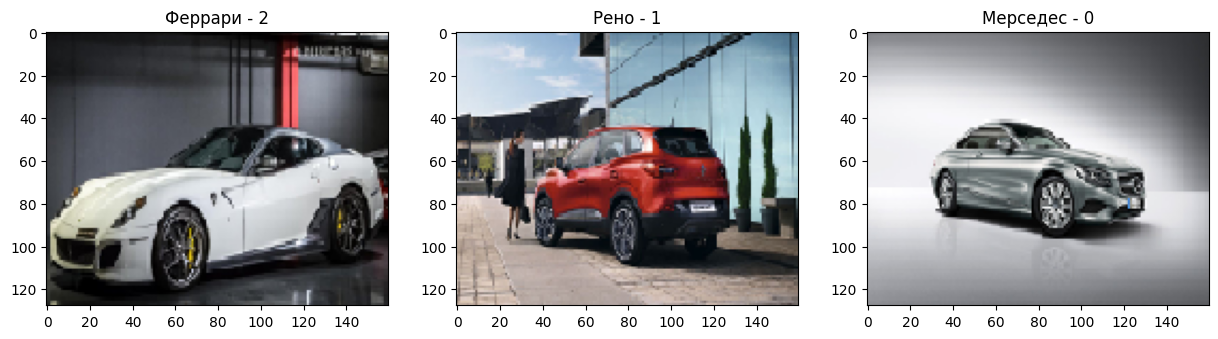

In [ ]:
# @title 1. Загрузка изображений и их перевод в numpy массив, создание меток классов

x_array = []
y_array = []

i = 0
fig, ax = plt.subplots(1, len(classes_names), figsize=(15,5))
for folder_name in dataset_path.iterdir():
    if folder_name.is_dir():
        for file_path in tqdm(folder_name.iterdir(), desc=folder_name.name):
            x_array.append(
                np.array(load_img(file_path, target_size=(height, width)))
                )
            y_array.append(classes_names.index(folder_name.name))
        ax[i].imshow(x_array[-1])
        ax[i].set_title(f"{folder_name.name} - {y_array[-1]}")
        i += 1
x_array = np.array(x_array)
y_array = np.array(y_array)

In [ ]:
# @title 2. применить скейлер и отнормировать входные данные
scaler = MinMaxScaler()
scaler.fit(x_array.reshape(-1, 1))

# Так как мы обучили скейлер на изображениях, высока вероятность получить минимальное и максимальное значение в диапазоне 0 - 255
# Проверим какие максимальное и минимальные значения получились после обучения скейлера
print(f'Минимальное значение: {getattr(scaler, "data_min_")}')
print(f'Максимальное значение: {getattr(scaler, "data_max_")}')

# Отнормируем массивы, используя обученный MinMaxScaler
orig_shape = x_array.shape
x_array = scaler.transform(x_array.reshape(-1, 1)).reshape(orig_shape)

Минимальное значение: [0.]
Максимальное значение: [255.]


In [ ]:
# @title 3. перевести выходные данные в формат One-Hot Encoding

# Перевод в формат One-Hot Encoding:
# метка 0 переводится в [1, 0, 0]
# метка 1 переводится в [0, 1, 0]
# метка 2 переводится в [0, 0, 1]
y_array = to_categorical(y_array, num_classes=len(classes_names))

In [ ]:
# @title 4. разделить на train/test выборку.

x_train, x_test, y_train, y_test = train_test_split(x_array, y_array, train_size=0.7, shuffle=True)
print(f"Размерность обучающей выборки: X - {x_train.shape}, Y - {y_train.shape}")
print(f"Размерность тестовой выборки: X - {x_test.shape}, Y - {y_test.shape}")

Размерность обучающей выборки: X - (2398, 128, 160, 3), Y - (2398, 3)
Размерность тестовой выборки: X - (1029, 128, 160, 3), Y - (1029, 3)


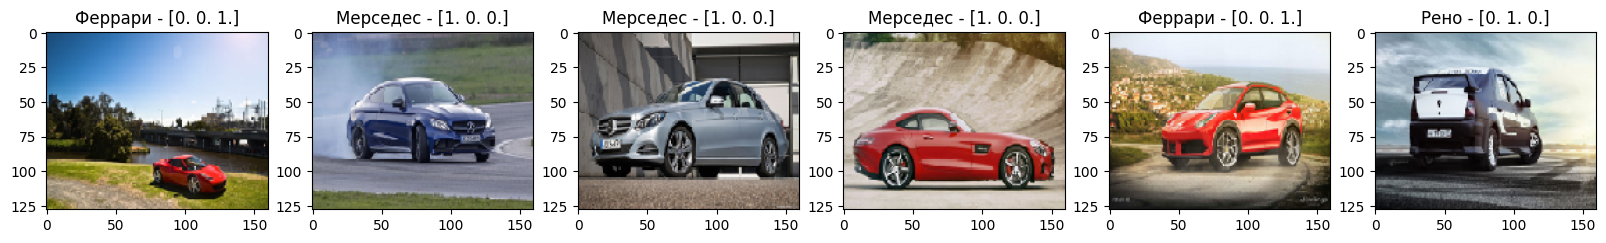

In [ ]:
# Выведем шесть случайных примеров

random_samples = random.sample(range(1, len(x_train)), 6)
random_x = x_train[random_samples]
random_y = y_train[random_samples]
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
for i, (x_ar, y_ar) in enumerate(zip(random_x, random_y)):
    cls_name = classes_names[np.argmax(y_ar)]
    ax[i].imshow(x_ar)
    ax[i].set_title(f"{cls_name} - {str(y_ar)}")

## Создание датасета с помощью Terra AI Datasets

Для создания датасета под задачу классификации изображений создадим экземпляр класса **ImageClassification** со следующими параметрами:

- source_path - путь к общей папке или список путей к папкам с изображениями;
- width - ширина изображения;
- height - высота изображения;
- preprocessing - скейлер. Варианты: "None", "MinMaxScaler", "TerraImageScaler";
- network - тип сетки. Варианты: "Convolutional", "Linear";
- process - тип обработки изображений. Варианты: "Fit", "Stretch", "Cut";
- train_size - размер обучающей выборки от 0 до 1;
- one_hot_encoding - перевод меток класса (output) в формат One-Hot Encoding.

### Вариант 1. No Scaler + Convolutional + Fit (160x128)

In [ ]:
img_cls_dataset = ImageClassification(
    source_path=['./cars'],  # Путь до общей папки с датасетом
    width=160,               # Ширина изображений
    height=128,              # Высота изображений
    preprocessing="None",    # Не использовать скейлер
    network="Convolutional", # Подготовить датасет для сверточной нейронной сети
    process='Fit',           # Вписать изображение в указанную ширину и высоту (если размер изображения не совпадает с указанным, в таких участках будут присовены нули)
    train_size=0.7,          # Размер тренировочной выборки - 70% от размера датасета
    one_hot_encoding=True    # Перевод меток класса в формат One-Hot Encoding
)

10:13:30 | Датасет подготовлен к началу формирования массивов
INFO:terra_ai_datasets.creation.utils:Датасет подготовлен к началу формирования массивов


Метод summary() позволяет вывести информацию о датасете:
- первые пять примеров датасета в виде таблицы;
- количество примеров в каждой из выборок;
- количество экземпляров классов для каждой выборки для задачи классификации.


In [ ]:
img_cls_dataset.summary()

,1_Image,2_Classification
0,cars/Рено/car__1001.png,Рено
1,cars/Рено/car__732.png,Рено
2,cars/Рено/car__570.png,Рено
3,cars/Мерседес/car__116.png,Мерседес
4,cars/Мерседес/car__1169.png,Мерседес



Кол-во примеров в train выборке: 2398
Кол-во примеров в val выборке: 1029

Список классов и количество примеров:


,Рено,Феррари,Мерседес
train,837,754,807
val,341,334,354


Метод .create(*use_generator=False*) начинает процесс создания numpy массивов для их последующего использования в процессе обучения нейросети.

При вызове метода создания с помощью генератора create(*use_generator=True*) создаются массивы только для тренировочной выборки для того, чтобы обучить объекты предобработки (скейлер, токенайзер, и т.д.). Сами массивы не сохраняются.

In [ ]:
img_cls_dataset.create(use_generator=False)

10:13:34 | Формирование массивов train - Image - 1_Image: 100%|██████████| 2398/2398 [00:03<00:00, 735.19it/s]
10:13:38 | Формирование массивов train - Classification - 2_Classification: 100%|██████████| 2398/2398 [00:00<00:00, 11711.50it/s]
10:13:38 | Формирование массивов val - Image - 1_Image: 100%|██████████| 1029/1029 [00:01<00:00, 556.53it/s]
10:13:40 | Формирование массивов val - Classification - 2_Classification: 100%|██████████| 1029/1029 [00:00<00:00, 8337.03it/s]


Метод .visualize() позволяет визуализировать данные в датасете. Его можно запустить как до метода .create(), так и после, с одной лишь разницей, что, при запуске до .create() не будут применены скейлеры (если были указаны при создании).

При каждом новом запуске берутся случайные семплы из тренировочной выборки для каждого из классов.

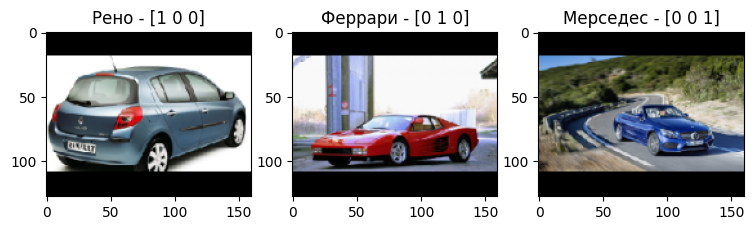

In [ ]:
img_cls_dataset.visualize()

Еще одной особенностью фреймворка является то, что для получения массивов используется итерируемый объект tf.data.Dataset. Его преимущество в том, что он подходит как для выдачи готовых массивов, так и для генераторов. Это означает, что, для вас, пользователю, обучение как на генераторе, так и на готвых массивах будет выглядеть одинаково.

**Важно!** При написании нейросети для входных и выходных слоёв в параметре *name* необходимо ввести соответствующее ему значение: "input_1", "output_1", ...

In [ ]:
model = Sequential()
model.add(Input(shape=(128, 160, 3), name="input_1"))  # Вход 1
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax', name="output_1"))  # Выход 1
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 128, 160, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 160, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 160, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 80, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 64, 80, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 163840)           

In [ ]:
model.fit(img_cls_dataset.dataset['train'].batch(64), epochs=15, validation_data=img_cls_dataset.dataset['val'].batch(64), verbose=1)

Epoch 1/15
38/38 [==============================] - 5s 86ms/step - loss: 1.6278 - accuracy: 0.4846 - val_loss: 0.9937 - val_accuracy: 0.4529
Epoch 2/15
38/38 [==============================] - 3s 78ms/step - loss: 0.9340 - accuracy: 0.5179 - val_loss: 0.9452 - val_accuracy: 0.4947
Epoch 3/15
38/38 [==============================] - 3s 82ms/step - loss: 0.8470 - accuracy: 0.5972 - val_loss: 0.9074 - val_accuracy: 0.5578
Epoch 4/15
38/38 [==============================] - 3s 80ms/step - loss: 0.7239 - accuracy: 0.6843 - val_loss: 0.8638 - val_accuracy: 0.6152
Epoch 5/15
38/38 [==============================] - 3s 82ms/step - loss: 0.5466 - accuracy: 0.7844 - val_loss: 0.9326 - val_accuracy: 0.6132
Epoch 6/15
38/38 [==============================] - 3s 83ms/step - loss: 0.3834 - accuracy: 0.8599 - val_loss: 1.0941 - val_accuracy: 0.6074
Epoch 7/15
38/38 [==============================] - 3s 86ms/step - loss: 0.2485 - accuracy: 0.9241 - val_loss: 0.9569 - val_accuracy: 0.6433
Epoch 8/15
38

Проверим точность предсказания модели на валидационной выборке и отобразим результат.

1/1 [==============================] - 0s 34ms/step


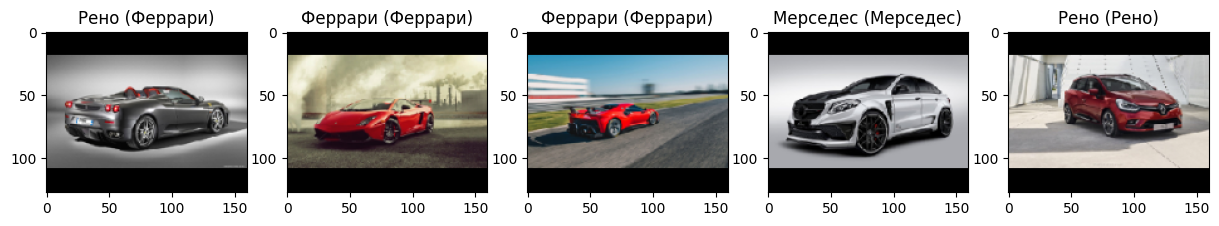

In [ ]:
visualize_img_cls_prediction(img_cls_dataset, model)

### Вариант 2. TerraImageScaler + Convolutional + Stretch (120x96)

In [ ]:
img_cls_dataset_2 = ImageClassification(
    source_path=['./cars'],            # Путь до общей папки с датасетом
    width=120,                         # Ширина изображений
    height=96,                         # Высота изображений
    preprocessing="TerraImageScaler",  # Использовать скейлер, который запоминает минимальное и максимальное значение каждого пикселя и каждого канала
    network="Convolutional",           # Подготовить датасет для сверточной нейронной сети
    process="Stretch",                 # Растянуть изображение до указанной выше ширины и высоты
    train_size=0.7,                    # Размер тренировочной выборки - 70% от размера датасета
    one_hot_encoding=True              # Перевод меток класса в формат One-Hot Encoding
)

09:59:51 | Датасет подготовлен к началу формирования массивов
INFO:terra_ai_datasets.creation.utils:Датасет подготовлен к началу формирования массивов


Метод summary() позволяет вывести информацию о датасете:
- первые пять примеров датасета в виде таблицы;
- количество примеров в каждой из выборок;
- количество экземпляров классов для каждой выборки для задачи классификации.


In [ ]:
img_cls_dataset_2.summary()

,1_Image,2_Classification
0,cars/Мерседес/car__855.png,Мерседес
1,cars/Феррари/car_Ferrari__639.png,Феррари
2,cars/Мерседес/car__991.png,Мерседес
3,cars/Мерседес/car__841.png,Мерседес
4,cars/Мерседес/car__1020.png,Мерседес



Кол-во примеров в train выборке: 2398
Кол-во примеров в val выборке: 1029

Список классов и количество примеров:


,Рено,Феррари,Мерседес
train,856,733,809
val,322,355,352


Метод .create(*use_generator=False*) начинает процесс создания numpy массивов для их последующего использования в процессе обучения нейросети.

При вызове метода создания с помощью генератора create(*use_generator=True*) создаются массивы только для тренировочной выборки для того, чтобы обучить объекты предобработки (скейлер, токенайзер, и т.д.). Сами массивы не сохраняются.

In [ ]:
# Создадим в этот раз датасет с генератором
img_cls_dataset_2.create(use_generator=True)

09:59:56 | Формирование массивов train - Image - 1_Image: 100%|██████████| 2398/2398 [00:04<00:00, 576.96it/s]
10:00:00 | Формирование массивов train - Classification - 2_Classification: 100%|██████████| 2398/2398 [00:00<00:00, 12586.38it/s]


Метод .visualize() позволяет визуализировать данные в датасете. Его можно запустить как до метода .create(), так и после, с одной лишь разницей, что, при запуске до .create() не будут применены скейлеры (если были указаны при создании).

При каждом новом запуске берутся случайные семплы для каждого из классов.

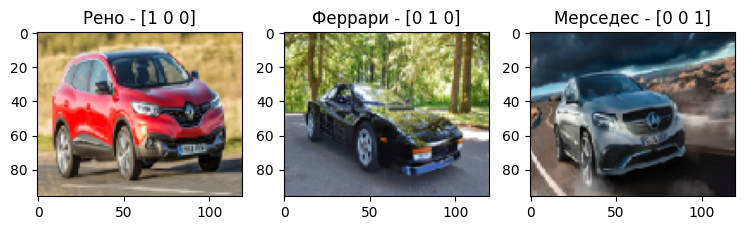

In [ ]:
img_cls_dataset_2.visualize()

В данном случае хоть мы и используем генератор, синтаксис нейронной сети ничем не отличается от предыдущей (за исключением другой входной размерности).

**Важно!** При написании нейросети для входных и выходных слоёв в параметре *name* необходимо ввести соответствующее ему значение: "input_1", "output_1", ...

In [ ]:
model = Sequential()
model.add(Input(shape=(96, 120, 3), name="input_1"))  # Вход 1
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax', name="output_1"))  # Выход 1
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 96, 120, 3)       12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 120, 32)       896       
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 120, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 48, 60, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 92160)            

In [ ]:
model.fit(img_cls_dataset_2.dataset['train'].batch(64), epochs=15, validation_data=img_cls_dataset_2.dataset['val'].batch(64), verbose=1)

Epoch 1/15
38/38 [==============================] - 20s 403ms/step - loss: 1.9016 - accuracy: 0.4003 - val_loss: 1.0423 - val_accuracy: 0.5569
Epoch 2/15
38/38 [==============================] - 11s 285ms/step - loss: 0.9423 - accuracy: 0.5142 - val_loss: 0.9591 - val_accuracy: 0.5607
Epoch 3/15
38/38 [==============================] - 11s 301ms/step - loss: 0.8397 - accuracy: 0.6272 - val_loss: 0.9022 - val_accuracy: 0.6142
Epoch 4/15
38/38 [==============================] - 11s 280ms/step - loss: 0.7030 - accuracy: 0.7006 - val_loss: 0.8626 - val_accuracy: 0.6142
Epoch 5/15
38/38 [==============================] - 10s 269ms/step - loss: 0.4975 - accuracy: 0.8098 - val_loss: 0.8590 - val_accuracy: 0.6045
Epoch 6/15
38/38 [==============================] - 11s 287ms/step - loss: 0.3199 - accuracy: 0.8841 - val_loss: 0.9234 - val_accuracy: 0.5957
Epoch 7/15
38/38 [==============================] - 11s 286ms/step - loss: 0.2389 - accuracy: 0.9162 - val_loss: 1.1284 - val_accuracy: 0.5617

Проверим точность предсказания модели на валидационной выборке и отобразим результат.

1/1 [==============================] - 0s 106ms/step


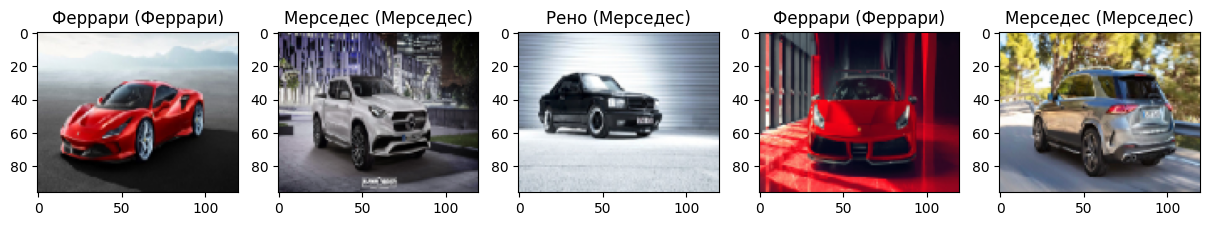

In [ ]:
visualize_img_cls_prediction(img_cls_dataset_2, model)

### Вариант 3. MinMaxScaler + Linear + Fit (160x128)

In [ ]:
img_cls_dataset_3 = ImageClassification(
    source_path=['./cars/Мерседес', './cars/Рено', './cars/Феррари'],  # Можно указать как родительскую папку (как в предыдущих примерах), так и списком.
    width=160,                                                         # Ширина изображений
    height=128,                                                        # Высота изображений
    preprocessing="MinMaxScaler",                                      # Использовать MinMaxScaler из sklearn
    network="Linear",                                                  # Подготовить датасет для полносвязной нейронной сети
    process="Fit",                                                     # Вписать изображение в указанную ширину и высоту (если размер изображения не совпадает с указанным, в таких участках будут присовены нули) 
    train_size=0.7,                                                    # Размер тренировочной выборки - 70% от размера датасета
    one_hot_encoding=True                                              # Перевод меток класса в формат One-Hot Encoding
    )

10:04:45 | Датасет подготовлен к началу формирования массивов
INFO:terra_ai_datasets.creation.utils:Датасет подготовлен к началу формирования массивов


Метод summary() позволяет вывести информацию о датасете:
- первые пять примеров датасета в виде таблицы;
- количество примеров в каждой из выборок;
- количество экземпляров классов для каждой выборки для задачи классификации.


In [ ]:
img_cls_dataset_3.summary()

,1_Image,2_Classification
0,cars/Мерседес/car__518.png,Мерседес
1,cars/Мерседес/car__775.png,Мерседес
2,cars/Феррари/car_Ferrari__558.png,Феррари
3,cars/Феррари/car_Ferrari__802.png,Феррари
4,cars/Мерседес/car__218.png,Мерседес



Кол-во примеров в train выборке: 2398
Кол-во примеров в val выборке: 1029

Список классов и количество примеров:


,Мерседес,Рено,Феррари
train,798,822,778
val,363,356,310


Метод .create(*use_generator=False*) начинает процесс создания numpy массивов для их последующего использования в процессе обучения нейросети.

In [ ]:
img_cls_dataset_3.create(use_generator=False)

10:04:49 | Формирование массивов train - Image - 1_Image: 100%|██████████| 2398/2398 [00:05<00:00, 402.73it/s]
10:04:57 | Формирование массивов train - Classification - 2_Classification: 100%|██████████| 2398/2398 [00:00<00:00, 13785.23it/s]
10:04:58 | Формирование массивов val - Image - 1_Image: 100%|██████████| 1029/1029 [00:01<00:00, 743.25it/s]
10:05:00 | Формирование массивов val - Classification - 2_Classification: 100%|██████████| 1029/1029 [00:00<00:00, 13902.74it/s]


В данном случае метод .visualize() не сможет визуализировать данные, так как в параметрах была указана network="Linear".

In [ ]:
# Видим, что размерность одного входного примера равна высоте*ширине*каналы, т.е. 160*128*3=61440
visualize_dataset_shapes(img_cls_dataset_3)


--- Выборка train ---
Вход 1: (2398, 61440)
Выход 1: (2398, 3)

--- Выборка val ---
Вход 1: (1029, 61440)
Выход 1: (1029, 3)


Особенностью режима Linear является то, что массивы изображений превращаются в вектор, которым можно обучить нейронную сеть из полносвязных слоев.

**Важно!** При написании нейросети для входных и выходных слоёв в параметре *name* необходимо ввести соответствующее ему значение: "input_1", "output_1", ...

In [ ]:
model = Sequential()
model.add(Input(shape=(128 * 160 * 3), name="input_1"))  # Вход 1
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax', name="output_1"))  # Выход 1
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              62915584  
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [ ]:
model.fit(img_cls_dataset_3.dataset['train'].batch(64), epochs=15, validation_data=img_cls_dataset_3.dataset['val'].batch(64), verbose=1)

Epoch 1/15
38/38 [==============================] - 8s 59ms/step - loss: 1.3041 - accuracy: 0.4466 - val_loss: 2.7332 - val_accuracy: 0.4587
Epoch 2/15
38/38 [==============================] - 1s 33ms/step - loss: 1.1129 - accuracy: 0.4983 - val_loss: 1.7964 - val_accuracy: 0.4840
Epoch 3/15
38/38 [==============================] - 1s 32ms/step - loss: 1.0010 - accuracy: 0.5471 - val_loss: 1.2792 - val_accuracy: 0.5092
Epoch 4/15
38/38 [==============================] - 1s 32ms/step - loss: 0.9599 - accuracy: 0.5751 - val_loss: 1.1316 - val_accuracy: 0.5355
Epoch 5/15
38/38 [==============================] - 1s 35ms/step - loss: 0.9221 - accuracy: 0.5980 - val_loss: 1.0417 - val_accuracy: 0.5578
Epoch 6/15
38/38 [==============================] - 1s 36ms/step - loss: 0.8949 - accuracy: 0.5967 - val_loss: 0.9949 - val_accuracy: 0.5432
Epoch 7/15
38/38 [==============================] - 2s 42ms/step - loss: 0.8529 - accuracy: 0.6113 - val_loss: 1.0371 - val_accuracy: 0.5413
Epoch 8/15
38

:Проверим точность предсказания модели на валидационной выборке и отобразим результат.

In [ ]:
visualize_img_cls_prediction(img_cls_dataset_3, model, 10, "Linear")

1/1 [==============================] - 0s 210ms/step
Пример 0: Истина: 0, Предсказание: 2
Пример 1: Истина: 2, Предсказание: 2
Пример 2: Истина: 1, Предсказание: 2
Пример 3: Истина: 2, Предсказание: 2
Пример 4: Истина: 1, Предсказание: 2
Пример 5: Истина: 2, Предсказание: 2
Пример 6: Истина: 1, Предсказание: 2
Пример 7: Истина: 1, Предсказание: 2
Пример 8: Истина: 0, Предсказание: 2
Пример 9: Истина: 0, Предсказание: 0


# Классификация текстов

In [ ]:
# Загрузка и распаковка датасета
load_text_classification_data()

Archive:  writers.zip
  inflating: /content/writers/Клиффорд Саймак/(Клиффорд_Саймак) Обучающая_5 вместе.txt  
  inflating: /content/writers/Макс Фрай/(Макс Фрай) Обучающая_5 вместе.txt  
  inflating: /content/writers/Булгаков/(Булгаков) Обучающая_5 вместе.txt  
  inflating: /content/writers/Рэй Брэдберри/(Рэй Брэдберри) Обучающая_22 вместе.txt  
  inflating: /content/writers/О. Генри/(О. Генри) Обучающая_50 вместе.txt  
  inflating: /content/writers/Стругацкие/(Стругацкие) Обучающая_5 вместе.txt  


## Создание датасета вручную

При решении задачи классификации изображений у нас должны получиться numpy массивы текстов по трем параметрам: Embedding, Bag of words и Word2Vec, а также их метки классов.

Этапы подготовки:

1. загрузить текстовые файлы, убрать знаки препинания, обрезать текст на кусочки по длине и шагу, и составить общий список таких кусочков. создать метки классов;
2. перевести выходные данные в формат One-Hot Encoding;
3. применить методы обработки текстов:
- Embedding;
- Bag of words;
- Word2Vec.

разделить на train/test выборку.

In [ ]:
dataset_path =  Path('./writers')
word2vec_size = 100                                                                         # Размер векторного пространства
max_words_count = 20000                                                                     # Максимальный размер словаря частотности слов
length = 1000                                                                               # Количество слов в одном примере
step = 100                                                                                  # Шаг сдвига при составлении примеров
filters = '–—!"#$%&()*+,-./:;<=>?@[\\]^«»№_`{|}~\t\n\xa0–\ufeff'                            # Символы, подлежащие удалению
classes_names = sorted([path.name for path in dataset_path.iterdir() if path.is_dir()][:2]) # Для ускорения возьмем первые две папки

In [ ]:
tokenizer = Tokenizer(num_words=max_words_count,
                      filters=filters,
                      lower=True,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>'
                      )

In [ ]:
# @title 1. загрузка текстовых файлов, удаление знаков препинания, обрезка текстов на кусочки
text_samples = []
y_array = []

idx = 0
for writer in classes_names:
    for text_path in dataset_path.joinpath(writer).iterdir():
        with open(text_path, 'r', encoding="utf-8") as text_file:
            text = ' '.join(text_to_word_sequence(
                text_file.read().strip(), **{'lower': False, 'filters': filters, 'split': ' '})
            ).split()
        
        # Сразу же добавляем текст в словарь частотности слов
        tokenizer.fit_on_texts(text)

        for i in tqdm(range(0, len(text), step), desc=writer):
            text_sample = text[i: i + length]
            text_samples.append(' '.join(text_sample))
            y_array.append(idx)
            if len(text_sample) < length:
                break
        idx += 1

y_array = np.array(y_array)
print(f"Количество примеров: {len(y_array)}")
print()
# Посмотрим на данные первого примера
print(f"Название класса: {classes_names[y_array[0]]}. Количество слов: {len(text_samples[0].split(' '))}")
print(text_samples[0])

Булгаков:   0%|          | 0/2617 [00:00<?, ?it/s]

О. Генри:   0%|          | 0/1607 [00:00<?, ?it/s]

Количество примеров: 4206

Название класса: Булгаков. Количество слов: 1000
Белая гвардия Посвящается 1 Любови Евгеньевне Белозерской 2 Пошел мелкий снег и вдруг повалил хло пьями Ветер завыл сделалась метель В одно мгновение темное небо смешалось с снежным морем Все исчезло Ну барин закричал ямщик беда буран 3 Капитанская дочка И судимы были мертвые 4 по написанному в книгах сообразно с делами своими Велик был год и страшен год по Рождестве Христовом 1918 от начала же революции второй 5 Был он обилен летом солнцем а зимою снегом и особенно высоко в небе стояли две звезды звезда пастушеская вечерняя Венера и красный дрожащий Марс 6 Но дни и в мирные и в кровавые годы летят как стрела и молодые Турбины 7 не заметили как в крепком морозе наступил белый мохнатый декабрь О елочный дед наш сверкающий снегом и счастьем Мама светлая королева где же ты 8 Через год после того как дочь Елена 9 повенчалась с капитаном Сергеем Ивановичем Тальбергом 10 и в ту неделю когда старший сын Алексей Василь

In [ ]:
# @title 2. перевести выходные данные в формат One-Hot Encoding

# Перевод в формат One-Hot Encoding:
# метка 0 переводится в [1, 0]
# метка 1 переводится в [0, 1]
y_array = to_categorical(y_array, num_classes=len(classes_names))

In [ ]:
# @title 3а. перевести тексты в формат Embedding

x_emb_array = []
for sample in tqdm(text_samples):
    emb_vector = tokenizer.texts_to_sequences([sample])[0]
    if len(emb_vector) < length:
        emb_vector += [0 for _ in range(length - len(emb_vector))]
    x_emb_array.append(emb_vector)

# Продемонстрируем первые двадцать слов последнего примера в оригинале, в формате Embedding, и в декодированном формате
print(f"Оригинал : {' '.join(sample.split(' ')[:20])}")
print(f"Embedding: {x_emb_array[-1][:20]}")
print(f"Декодинг : {' '.join([tokenizer.index_word[idx] for idx in x_emb_array[-1][:20]])}")
x_emb_array = np.array(x_emb_array)
print(f"Размерность полученного массива:{x_emb_array.shape}")

  0%|          | 0/4206 [00:00<?, ?it/s]

Оригинал : Джо ничего не оставалось как только улыбнуться тоже В сравнении с масштабами этого дома мистер э… м да заметил Дебстер
Embedding: [1715, 85, 5, 1843, 10, 38, 8775, 263, 3, 7094, 7, 1, 69, 237, 197, 3136, 409, 43, 711, 4997]
Декодинг : джо ничего не оставалось как только улыбнуться тоже в сравнении с <UNK> этого дома мистер э… м да заметил дебстер
Размерность полученного массива:(4206, 1000)


In [ ]:
# Разделение на train/test выборки

x_train, x_test, y_train, y_test = train_test_split(x_emb_array, y_array, train_size=0.7, shuffle=True)
print(f"Размерность обучающей выборки: X - {x_train.shape}, Y - {y_train.shape}")
print(f"Размерность тестовой выборки: X - {x_test.shape}, Y - {y_test.shape}")

Размерность обучающей выборки: X - (2944, 1000), Y - (2944, 2)
Размерность тестовой выборки: X - (1262, 1000), Y - (1262, 2)


In [ ]:
# Удаляем массивы для избежания вылета по памяти
del x_emb_array
del x_train, x_test
del y_train, y_test

In [ ]:
# @title 3b. перевести тексты в формат Bag of words

x_bow_array = []
for sample in tqdm(text_samples):
    bow_vector = tokenizer.texts_to_matrix([sample])[0].astype(np.uint8)
    x_bow_array.append(bow_vector)

x_bow_array = np.array(x_bow_array)
print(f"Размерность полученного массива:{x_bow_array.shape}")

  0%|          | 0/4206 [00:00<?, ?it/s]

Размерность полученного массива:(4206, 20000)


In [ ]:
# Разделение на train/test выборки

x_train, x_test, y_train, y_test = train_test_split(x_bow_array, y_array, train_size=0.7, shuffle=True)
print(f"Размерность обучающей выборки: X - {x_train.shape}, Y - {y_train.shape}")
print(f"Размерность тестовой выборки: X - {x_test.shape}, Y - {y_test.shape}")

Размерность обучающей выборки: X - (2944, 20000), Y - (2944, 2)
Размерность тестовой выборки: X - (1262, 20000), Y - (1262, 2)


In [ ]:
# Удаляем массивы для избежания вылета по памяти
del x_bow_array
del x_train, x_test
del y_train, y_test

In [ ]:
# @title 3c. перевести тексты в формат Word2Vec

# Создание и обучение экземпляра Word2Vec (~65 секунд)
text_list = [elem.split(' ') for elem in text_samples]
word2vec = Word2Vec(text_list, size=word2vec_size)

x_word2vec_array = []
for sample in tqdm(text_samples):
    text_array = []
    for word in sample.split(' '):
        try:
            text_array.append(word2vec.wv[word])
        except KeyError:
            text_array.append(np.zeros((word2vec_size,)))
    if len(text_array) < length:
        words_to_add = [[0 for _ in range(word2vec_size)]
                        for _ in range(length - len(text_array))]
        text_array += words_to_add
    x_word2vec_array.append(text_array)
x_word2vec_array = np.array(x_word2vec_array)

print(f"Размерность полученного массива:{x_word2vec_array.shape}")

  0%|          | 0/4206 [00:00<?, ?it/s]

Размерность полученного массива:(4206, 1000, 100)


In [ ]:
# Разделение на train/test выборки

x_train, x_test, y_train, y_test = train_test_split(x_word2vec_array, y_array, train_size=0.7, shuffle=True)
print(f"Размерность обучающей выборки: X - {x_train.shape}, Y - {y_train.shape}")
print(f"Размерность тестовой выборки: X - {x_test.shape}, Y - {y_test.shape}")

Размерность обучающей выборки: X - (2944, 1000, 100), Y - (2944, 2)
Размерность тестовой выборки: X - (1262, 1000, 100), Y - (1262, 2)


In [ ]:
# Удаляем массивы для избежания вылета по памяти
del x_word2vec_array
del x_train, x_test
del y_train, y_test

## Создание датасета с помощью Terra AI Datasets

Для создания датасета под задачу классификации текстов создадим экземпляр класса **TextClassification** со следующими параметрами:

Параметры:
- source_path - список путей к папкам с текстовыми файлами;
- train_size - размер обучающей выборки от 0 до 1;
- max_words_count - максимальное количество слов в Tokenizer;
- mode - режим обработки текстов. Варианты: "Full", "Length and step";
- preprocessing - метод обработки. Варианты: "Embedding", "Bag of words";
- max_words - ОПЦИОНАЛЬНО при mode == "Full" - количество слов из одного файла;
- length - ОПЦИОНАЛЬНО при mode == "Length and step" - количество слов в одном примере;
- step - ОПЦИОНАЛЬНО при mode == "Length and step" - шаг окна разбивки текстов;
- pymorphy - приведение слов к нормальной форме (значительно увеличивает время обработки);
- one_hot_encoding - перевод меток класса (output) в формат One-Hot Encoding.

### Embedding + Length and step

In [ ]:
from terra_ai_datasets.create import TextClassification

text_cls_dataset_1 = TextClassification(
    source_path=["./writers/Булгаков", "./writers/О. Генри"],  # Список путей до папок
    train_size=0.7,                                            # Размер тренировочной выборки - 70% от размера датасета
    max_words_count=20000,                                     # Максимальное количество уникальных слов, которое "запоминает" токенайзер
    mode="Length and step",                                    # Режим обработки текстов, при котором текст делится на части
    preprocessing="Embedding",                                 # Метод обработки, при котором каждому слову назначается уникальный индекс, исходя из словаря частотности слов
    length=2000,                                               # Количество слов в одном примере
    step=200,                                                  # Размер шага окна обработки текстов
    one_hot_encoding=True,                                     # Перевод меток класса в формат One-Hot Encoding
    pymorphy=False                                             # Перевод слов в нормальную форму (значительно увеличивает время обработки)
)

10:16:11 | Датасет подготовлен к началу формирования массивов
INFO:terra_ai_datasets.creation.utils:Датасет подготовлен к началу формирования массивов


Воспользуемся методом summary() чтобы отобразить информацию о сфромированном датасете:

In [ ]:
text_cls_dataset_1.summary()

,1_Text,2_Classification
0,интересно Ну ладно Физиологи будут в восторге ...,Булгаков
1,где вы служили доктор до сего времени В тысяча...,Булгаков
2,правда ли Есть что нибудь что могло бы застави...,О. Генри
3,тот дьявольски усмехнувшись молвил Галаньба не...,Булгаков
4,я старался об одном как можно меньше истратить...,Булгаков



Кол-во примеров в train выборке: 1466
Кол-во примеров в val выборке: 629

Список классов и количество примеров:


,Булгаков,О. Генри
train,897,569
val,403,226


Метод .create(use_generator=False) начинает процесс создания numpy массивов для их последующего использования в процессе обучения нейросети.

In [ ]:
text_cls_dataset_1.create(use_generator=False)

10:16:19 | Формирование массивов train - Text - 1_Text: 100%|██████████| 1466/1466 [00:00<00:00, 13189.30it/s]
10:16:27 | Формирование массивов train - Classification - 2_Classification: 100%|██████████| 1466/1466 [00:00<00:00, 8289.53it/s]
10:16:28 | Формирование массивов val - Text - 1_Text: 100%|██████████| 629/629 [00:00<00:00, 9272.65it/s]
10:16:30 | Формирование массивов val - Classification - 2_Classification: 100%|██████████| 629/629 [00:00<00:00, 13621.17it/s]


При создании датасета был создан объект Tokenizer, который хранит в себе словарь частотности слов. Также были занесены в таблицу тексты в обработанном виде (избавились от пунктуации, применили pymorphy).

In [ ]:
# 20 самых частовстречающихся слов:
most_common_words(text_cls_dataset_1, 20)

{1: '<UNK>',
 2: 'и',
 3: 'в',
 4: 'на',
 5: 'не',
 6: 'что',
 7: 'с',
 8: 'я',
 9: 'он',
 10: 'как',
 11: 'его',
 12: 'а',
 13: 'к',
 14: 'у',
 15: 'но',
 16: 'по',
 17: 'из',
 18: 'это',
 19: 'то',
 20: 'за'}

In [ ]:
text_cls_dataset_1.dataframe['train'].head()

,1_Text,2_Classification
0,интересно Ну ладно Физиологи будут в восторге ...,Булгаков
1,где вы служили доктор до сего времени В тысяча...,Булгаков
2,правда ли Есть что нибудь что могло бы застави...,О. Генри
3,тот дьявольски усмехнувшись молвил Галаньба не...,Булгаков
4,я старался об одном как можно меньше истратить...,Булгаков


In [ ]:
model = Sequential()
model.add(Input(shape=(2000,), name="input_1"))
model.add(Embedding(20000, 100, input_length=2000))
model.add(SpatialDropout1D(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', name="output_1"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 100)         2000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 2000, 100)        0         
 ropout1D)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 200000)            0         
                                                                 
 batch_normalization_6 (Batc  (None, 200000)           800000    
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 200)               40000200  
                                                                 
 dropout_9 (Dropout)         (None, 200)              

In [ ]:
model.fit(text_cls_dataset_1.dataset['train'].batch(32), epochs=15, validation_data=text_cls_dataset_1.dataset['val'].batch(32), verbose=1)

Epoch 1/15
46/46 [==============================] - 20s 382ms/step - loss: 0.6790 - accuracy: 0.8411 - val_loss: 1.8400 - val_accuracy: 0.6407
Epoch 2/15
46/46 [==============================] - 1s 27ms/step - loss: 0.0529 - accuracy: 0.9823 - val_loss: 0.6978 - val_accuracy: 0.6407
Epoch 3/15
46/46 [==============================] - 1s 29ms/step - loss: 0.0203 - accuracy: 0.9952 - val_loss: 0.6749 - val_accuracy: 0.6407
Epoch 4/15
46/46 [==============================] - 1s 31ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.7037 - val_accuracy: 0.6407
Epoch 5/15
46/46 [==============================] - 1s 30ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.7286 - val_accuracy: 0.6407
Epoch 6/15
46/46 [==============================] - 1s 28ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.7523 - val_accuracy: 0.6407
Epoch 7/15
46/46 [==============================] - 1s 27ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.7504 - val_accuracy: 0.6407
Epoch 8/15


Проверим точность предсказания модели на валидационной выборке и отобразим результат.

In [ ]:
def visualize_txt_cls_prediction(dataset, model, num_samples=10, dataset_type="Embedding"):

    classes_names = dataset.put_instructions[2]['2_Classification'].parameters.classes_names
    index_word = dataset.preprocessing['1_Text'].index_word

    inp, out, pred = next(dataset.evaluate_on_model(model, batch_size=num_samples))

    y_val = np.argmax(out['output_1'].numpy(), axis=1)
    y_pred = np.argmax(pred, axis=1)

    for i, (sample, y_t, y_p) in enumerate(zip(inp["input_1"], y_val, y_pred)):
        sample_text = [index_word[s] if s > 0 else "" for s in sample.numpy()]
        print(f'Правда: {classes_names[y_t]}, Предсказание: {classes_names[y_p]}, Вход: {" ".join(sample_text[:8])} ...')

In [ ]:
visualize_txt_cls_prediction(text_cls_dataset_1, model, 10, "Embedding")

1/1 [==============================] - 0s 35ms/step
Правда: Булгаков, Предсказание: Булгаков, Вход: <UNK> во время последних бессонных ночей и пришла ...
Правда: О. Генри, Предсказание: О. Генри, Вход: возьму все эти деньги и <UNK> профессору черубуско ...
Правда: Булгаков, Предсказание: Булгаков, Вход: говорите я <UNK> моего друга шпака бунша а ...
Правда: Булгаков, Предсказание: Булгаков, Вход: вы сына господина поклена держали в руках я ...
Правда: Булгаков, Предсказание: Булгаков, Вход: <UNK> если по мнению людовика крессе можно желать ...
Правда: Булгаков, Предсказание: Булгаков, Вход: с ним сидела <UNK> <UNK> он <UNK> говорил ...
Правда: О. Генри, Предсказание: О. Генри, Вход: никогда не смеются как смеются их братья на ...
Правда: Булгаков, Предсказание: Булгаков, Вход: <UNK> взором боясь что откуда нибудь <UNK> бритый ...
Правда: О. Генри, Предсказание: О. Генри, Вход: было <UNK> узнать по его белой шляпе <UNK> ...
Правда: Булгаков, Предсказание: Булгаков, Вход: что ходит меж л

### Bag of words + Length and step

In [ ]:
text_cls_dataset_2 = TextClassification(
    source_path=["./writers/Булгаков", "./writers/О. Генри"],  # Список путей до папок
    train_size=0.7,                                            # Размер тренировочной выборки - 70% от размера датасета
    max_words_count=20000,                                     # Максимальное количество уникальных слов, которое "запоминает" токенайзер
    mode="Length and step",                                    # Режим обработки текстов, при котором текст делится на части
    preprocessing="Bag of words",                              # Метод обработки "Мешок слов"
    length=2000,                                               # Количество слов в одном примере
    step=200,                                                  # Размер шага окна обработки текстов
    one_hot_encoding=True,                                     # Перевод меток класса в формат One-Hot Encoding
    pymorphy=False                                             # Перевод слов в нормальную форму (значительно увеличивает время обработки)
)

10:21:14 | Датасет подготовлен к началу формирования массивов
INFO:terra_ai_datasets.creation.utils:Датасет подготовлен к началу формирования массивов


Воспользуемся методом summary() чтобы отобразить информацию о сфромированном датасете:

In [ ]:
text_cls_dataset_2.summary()

,1_Text,2_Classification
0,удавалось написать ничего что доставило бы мне...,Булгаков
1,В придворном журнале ни словом не было упомяну...,Булгаков
2,Мольера и граф де Жонзак приятель Шапеля Компа...,Булгаков
3,мою пользу Но конечно ее несколько ошеломило о...,О. Генри
4,восстание из за телеграммы которая пришла на в...,О. Генри



Кол-во примеров в train выборке: 1466
Кол-во примеров в val выборке: 629

Список классов и количество примеров:


,Булгаков,О. Генри
train,893,573
val,407,222


Метод .create(use_generator=False) начинает процесс создания numpy массивов для их последующего использования в процессе обучения нейросети.

In [ ]:
text_cls_dataset_2.create(use_generator=False)

10:21:19 | Формирование массивов train - Text - 1_Text: 100%|██████████| 1466/1466 [00:00<00:00, 9536.06it/s]
10:21:34 | Формирование массивов train - Classification - 2_Classification: 100%|██████████| 1466/1466 [00:00<00:00, 6253.10it/s]
10:21:35 | Формирование массивов val - Text - 1_Text: 100%|██████████| 629/629 [00:00<00:00, 6523.04it/s]
10:21:38 | Формирование массивов val - Classification - 2_Classification: 100%|██████████| 629/629 [00:00<00:00, 5846.28it/s]


In [ ]:
# При использовании режима Bag of words создается вектор длиной в max_words_count
visualize_dataset_shapes(text_cls_dataset_2)


--- Выборка train ---
Вход 1: (1466, 20000)
Выход 1: (1466, 2)

--- Выборка val ---
Вход 1: (629, 20000)
Выход 1: (629, 2)


При создании датасета был создан объект Tokenizer, который хранит в себе словарь частотности слов. Также были занесены в таблицу тексты в обработанном виде.

In [ ]:
most_common_words(text_cls_dataset_2, 20)

{1: '<UNK>',
 2: 'и',
 3: 'в',
 4: 'на',
 5: 'не',
 6: 'что',
 7: 'с',
 8: 'он',
 9: 'я',
 10: 'его',
 11: 'как',
 12: 'а',
 13: 'к',
 14: 'у',
 15: 'но',
 16: 'по',
 17: 'из',
 18: 'это',
 19: 'то',
 20: 'за'}

In [ ]:
text_cls_dataset_1.dataframe['train'].head()

,1_Text,2_Classification
0,интересно Ну ладно Физиологи будут в восторге ...,Булгаков
1,где вы служили доктор до сего времени В тысяча...,Булгаков
2,правда ли Есть что нибудь что могло бы застави...,О. Генри
3,тот дьявольски усмехнувшись молвил Галаньба не...,Булгаков
4,я старался об одном как можно меньше истратить...,Булгаков


In [ ]:
model = Sequential()
model.add(Input(shape=(20000,), name="input_1"))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(150, activation='tanh'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax', name="output_1"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 800)               16000800  
                                                                 
 dropout_10 (Dropout)        (None, 800)               0         
                                                                 
 dense_8 (Dense)             (None, 400)               320400    
                                                                 
 dropout_11 (Dropout)        (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 150)               60150     
                                                                 
 dropout_12 (Dropout)        (None, 150)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 150)             

In [ ]:
model.fit(text_cls_dataset_2.dataset['train'].batch(32), epochs=15, validation_data=text_cls_dataset_2.dataset['val'].batch(32), verbose=1)

Epoch 1/15
46/46 [==============================] - 3s 12ms/step - loss: 0.0606 - accuracy: 0.9734 - val_loss: 2.8135e-05 - val_accuracy: 1.0000
Epoch 2/15
46/46 [==============================] - 0s 9ms/step - loss: 7.6236e-04 - accuracy: 1.0000 - val_loss: 1.1176e-05 - val_accuracy: 1.0000
Epoch 3/15
46/46 [==============================] - 0s 9ms/step - loss: 3.7757e-04 - accuracy: 1.0000 - val_loss: 7.5681e-06 - val_accuracy: 1.0000
Epoch 4/15
46/46 [==============================] - 0s 9ms/step - loss: 4.3444e-04 - accuracy: 1.0000 - val_loss: 5.2488e-06 - val_accuracy: 1.0000
Epoch 5/15
46/46 [==============================] - 0s 9ms/step - loss: 3.1203e-04 - accuracy: 1.0000 - val_loss: 3.3494e-06 - val_accuracy: 1.0000
Epoch 6/15
46/46 [==============================] - 0s 9ms/step - loss: 1.9088e-04 - accuracy: 1.0000 - val_loss: 2.9537e-06 - val_accuracy: 1.0000
Epoch 7/15
46/46 [==============================] - 0s 9ms/step - loss: 1.8395e-04 - accuracy: 1.0000 - val_loss: 1

Проверим точность предсказания модели на валидационной выборке и отобразим результат. Так как мы использовали режим Bag of words, порядок слов в массивах не был учтен. Соответственно выведем просто истинный класс и предсказанный.

In [ ]:
visualize_txt_cls_prediction(text_cls_dataset_2, model, 10, "Bag of words")

1/1 [==============================] - 0s 123ms/step
Правда: О. Генри, Предсказание: О. Генри
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: О. Генри, Предсказание: О. Генри
Правда: О. Генри, Предсказание: О. Генри
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: О. Генри, Предсказание: О. Генри


In [ ]:
classes_names = text_cls_dataset_2.put_instructions[2]['2_Classification'].parameters.classes_names
index_word = text_cls_dataset_2.preprocessing['1_Text'].index_word

num_samples = 10
inp, out, pred = next(text_cls_dataset_2.evaluate_on_model(model, batch_size=num_samples))  # Возьмем первые 10 примеров из валидационной выборки

y_val = np.argmax(out['output_1'].numpy(), axis=1)                                          # Использовали One-Hot Encoding
y_pred = np.argmax(pred, axis=1)                                                            # Использовали One-Hot Encoding

for i, (sample, y_t, y_p) in enumerate(zip(inp["input_1"], y_val, y_pred)):
    print(f'Правда: {classes_names[y_t]}, Предсказание: {classes_names[y_p]}')

1/1 [==============================] - 0s 68ms/step
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: О. Генри, Предсказание: О. Генри
Правда: О. Генри, Предсказание: О. Генри
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков


### Word2Vec + Length and step

In [ ]:
text_cls_dataset_3 = TextClassification(
    source_path=["./writers/Булгаков", "./writers/О. Генри"],  # Список путей до папок
    train_size=0.7,                                            # Размер тренировочной выборки - 70% от размера датасета
    mode="Length and step",                                    # Режим обработки текстов, при котором текст делится на части
    preprocessing="Word2Vec",                                  # Метод обработки, при котором каждому слову назначается соответствующий вектор из словаря векторного представления слов
    word2vec_size=100,                                         # При использовании режима Word2Vec этот параметр становится обязательным
    length=2000,                                               # Количество слов в одном примере
    step=200,                                                  # Размер шага окна обработки текстов
    one_hot_encoding=True,                                     # Перевод меток класса в формат One-Hot Encoding
    pymorphy=False                                             # Перевод слов в нормальную форму (значительно увеличивает время обработки)
)

11:00:16 | Датасет подготовлен к началу формирования массивов
INFO:terra_ai_datasets.creation.utils:Датасет подготовлен к началу формирования массивов


Воспользуемся методом summary() чтобы отобразить информацию о сфромированном датасете:

In [ ]:
text_cls_dataset_3.summary()

,1_Text,2_Classification
0,ее поклонников и знаменосцев бросивши врученно...,Булгаков
1,Рио Браво вряд ли нашелся бы храбрец который р...,О. Генри
2,поскакал к Волчьему Броду Он привязал солового...,О. Генри
3,любил веселиться с комфортом Он выбрал чистое ...,О. Генри
4,для смягчения тишины на овечьем ранчо Что до м...,О. Генри



Кол-во примеров в train выборке: 1466
Кол-во примеров в val выборке: 629

Список классов и количество примеров:


,Булгаков,О. Генри
train,904,562
val,396,233


Метод .create(use_generator=False) начинает процесс создания numpy массивов для их последующего использования в процессе обучения нейросети.

In [ ]:
text_cls_dataset_3.create(use_generator=False)

11:00:58 | Формирование массивов train - Text - 1_Text: 100%|██████████| 1466/1466 [00:00<00:00, 17318.85it/s]
11:01:14 | Формирование массивов train - Classification - 2_Classification: 100%|██████████| 1466/1466 [00:00<00:00, 3324.67it/s]
11:01:21 | Формирование массивов val - Text - 1_Text: 100%|██████████| 629/629 [00:00<00:00, 16864.73it/s]
11:01:26 | Формирование массивов val - Classification - 2_Classification: 100%|██████████| 629/629 [00:00<00:00, 8914.37it/s]


In [ ]:
# При использовании режима Word2Vec каждое слово переводится в векторное представление длиной в word2vec_size (указали при создании, в нашем случае 100).
# Так как в каждом примере по 2000 слов (length=2000, указали при создании), для каждого входного примера массив имеет размерность (2000, 100).

visualize_dataset_shapes(text_cls_dataset_3)


--- Выборка train ---
Вход 1: (1466, 2000, 100)
Выход 1: (1466, 2)

--- Выборка val ---
Вход 1: (629, 2000, 100)
Выход 1: (629, 2)


In [ ]:
model = Sequential()
model.add(Input((2000, 100), name="input_1"))
model.add(Conv1D(16, 3, padding='same', activation='relu'))
model.add(Conv1D(16, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax', name="output_1"))
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
model.fit(text_cls_dataset_3.dataset['train'].batch(32), epochs=15, validation_data=text_cls_dataset_3.dataset['val'].batch(32), verbose=1)

Epoch 1/15
46/46 [==============================] - 19s 150ms/step - loss: 2.8614 - accuracy: 0.6153 - val_loss: 0.3340 - val_accuracy: 0.8633
Epoch 2/15
46/46 [==============================] - 4s 91ms/step - loss: 0.0830 - accuracy: 0.9795 - val_loss: 0.0796 - val_accuracy: 0.9762
Epoch 3/15
46/46 [==============================] - 5s 102ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 0.9921
Epoch 4/15
46/46 [==============================] - 4s 85ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0335 - val_accuracy: 0.9921
Epoch 5/15
46/46 [==============================] - 4s 79ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9936
Epoch 6/15
46/46 [==============================] - 5s 108ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9952
Epoch 7/15
46/46 [==============================] - 3s 76ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 8/1

Проверим точность предсказания модели на валидационной выборке и отобразим результат. Выведем истинный класс и предсказанный.

In [ ]:
visualize_txt_cls_prediction(text_cls_dataset_3, model, 10, "Word2Vec")

1/1 [==============================] - 0s 441ms/step
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: О. Генри, Предсказание: О. Генри
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: Булгаков, Предсказание: Булгаков
Правда: О. Генри, Предсказание: О. Генри
Правда: О. Генри, Предсказание: О. Генри


In [ ]:
# Удаляем чтобы освободить ОЗУ
del text_cls_dataset_3

# Временные ряды

In [ ]:
# Загрузка и распаковка датасета
load_timeseries_data()

Archive:  shares.zip
  inflating: /content/shares/YNDX_1h.csv  
  inflating: /content/shares/bitcoin.csv  
  inflating: /content/shares/petrol_price.csv  
  inflating: /content/shares/lukoil.csv  
  inflating: /content/shares/GAZP_1d.csv  
  inflating: /content/shares/GAZP_1h.csv  
  inflating: /content/shares/POLY_1h.csv  
  inflating: /content/shares/POLYa_1d.csv  
  inflating: /content/shares/POLYb_1d.csv  
  inflating: /content/shares/YNDX_1d.csv  
  inflating: /content/shares/SBER.csv  
  inflating: /content/shares/stocks.csv  


## Создание датасета вручную

При решении задачи временных рядов необходимо подготовить numpy массивы, включающие в себя один или несколько временных рядов, используемые в качестве входных данных, а также временные ряды, которые необходимо предсказать.

Этапы подготовки:

1. загрузить таблицу, обрезать числовые табличные данные на кусочки по длине и шагу;
2. применить скейлинг к полученным массивам;
3. разделить на train/test выборку.

In [ ]:
csv_path =  Path('shares/YNDX_1d.csv')
inputs = ["<OPEN>", "<HIGH>", "<LOW>", "<CLOSE>"]  # Колонки, используемые в качестве входных данных
outputs = ["<CLOSE>"]                              # Колонки, используемые в качестве выходных данных
length = 100                                       # Количество  строк (временных значений), используемый во входных массивах
step = 100                                         # Шаг окна
depth = 30                                         # Глубина предсказания

In [ ]:
df = pd.read_csv(csv_path)
df.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,YNDX,60,20160104,100000,1148.9,1157.9,1148.9,1150.8,413
1,YNDX,60,20160104,110000,1150.0,1150.0,1132.8,1132.8,2273
2,YNDX,60,20160104,120000,1133.1,1133.1,1128.0,1128.2,358
3,YNDX,60,20160104,130000,1129.7,1130.0,1129.7,1130.0,529
4,YNDX,60,20160104,140000,1130.0,1131.9,1112.7,1112.9,6450


In [ ]:
# @title 1. загружаем таблицу и обрезаем табличные данные на кусочки по длине и шагу

df = pd.read_csv(csv_path)

x_array = []
y_array = []

for i in range(0, len(df) - length, step):
    inp_arr = []
    out_arr = []
    for col_name in inputs:
        inp_arr.append(np.array(df.loc[i:i+length - 1, col_name].tolist()))
    for col_name in outputs:
        out_arr.append(np.array(df.loc[i+length:i+length+depth - 1, col_name].tolist()))
    x_array.append(inp_arr)
    y_array.append(out_arr)

x_array = np.moveaxis(np.array(x_array), 2, 1)
y_array = np.moveaxis(np.array(y_array), 2, 1)

print(f'Размерность входного массива: {x_array.shape}')
print(f'Размерность выходного массива: {y_array.shape}')

Размерность входного массива: (113, 100, 4)
Размерность выходного массива: (113, 30, 1)


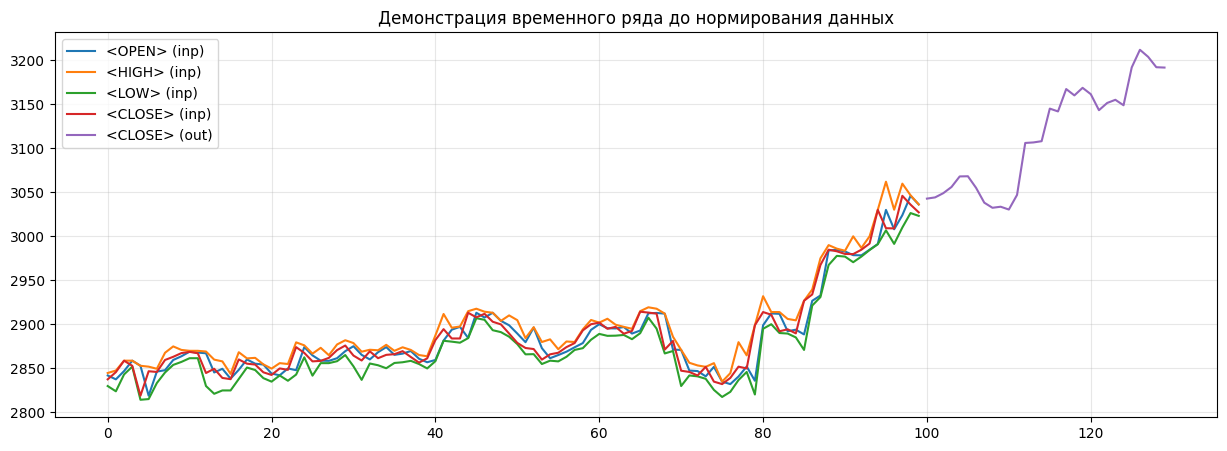

In [ ]:
sample_idx = 100

plt.figure(figsize=(15, 5))
for i, col_name in enumerate(inputs):
    plt.plot(x_array[sample_idx, :, i], label=f"{col_name} (inp)")
for i, col_name in enumerate(outputs):
    plt.plot([None for _ in range(100)] + y_array[sample_idx, :, i].tolist(), label=f"{col_name} (out)")
plt.grid(True, alpha=0.3)
plt.title('Демонстрация временного ряда до нормирования данных')
plt.legend()
plt.show()

Колонка "<OPEN>": Среднее: 2194.9885663716814, Дисперсия: 850948.760391396
Колонка "<HIGH>": Среднее: 2204.2682566371677, Дисперсия: 858098.0205613853
Колонка "<LOW>": Среднее: 2184.9736902654863, Дисперсия: 843028.9235175323
Колонка "<CLOSE>": Среднее: 2195.0193805309736, Дисперсия: 851216.6614208552

Колонка "<CLOSE>": Среднее: 2208.9889085545724, Дисперсия: 858179.4855583956


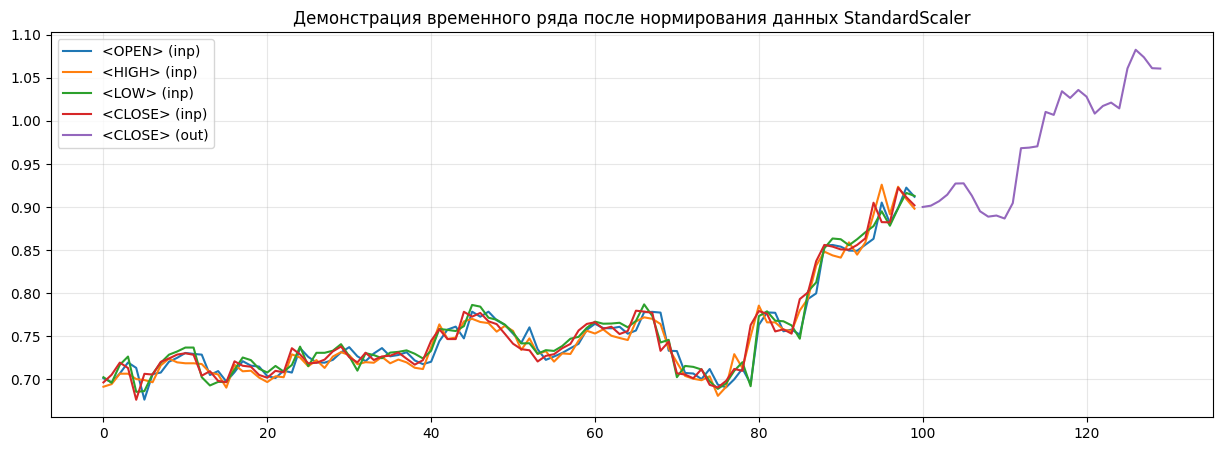

In [ ]:
# @title 2а. применяем скейлинг к полученным массивам (StandardScaler)

x_array_standard = x_array.copy()
y_array_standard = y_array.copy()
for i, col_name in enumerate(inputs):
    globals()[f"inp_scaler_{i}"] = StandardScaler()
    globals()[f"inp_scaler_{i}"].fit(x_array_standard[:, :, i].reshape(-1, 1))
    orig_shape = x_array_standard[:, :, i].shape
    transformed_arr = globals()[f"inp_scaler_{i}"].transform(x_array_standard[:, :, i].reshape(-1, 1))
    x_array_standard[:, :, i] = transformed_arr.reshape(orig_shape)
    print(f'Колонка "{col_name}": Среднее: {globals()[f"inp_scaler_{i}"].__dict__.get("mean_")[0]}, Дисперсия: {globals()[f"inp_scaler_{i}"].__dict__.get("var_")[0]}')
print()
for i, col_name in enumerate(outputs):
    globals()[f"out_scaler_{i}"] = StandardScaler()
    globals()[f"out_scaler_{i}"].fit(y_array_standard[:, :, i].reshape(-1, 1))
    orig_shape = y_array_standard[:, :, i].shape
    transformed_arr = globals()[f"out_scaler_{i}"].transform(y_array_standard[:, :, i].reshape(-1, 1))
    y_array_standard[:, :, i] = transformed_arr.reshape(orig_shape)
    print(f'Колонка "{col_name}": Среднее: {globals()[f"out_scaler_{i}"].__dict__.get("mean_")[0]}, Дисперсия: {globals()[f"out_scaler_{i}"].__dict__.get("var_")[0]}')

sample_idx = 100

plt.figure(figsize=(15, 5))
for i, col_name in enumerate(inputs):
    plt.plot(x_array_standard[sample_idx, :, i], label=f"{col_name} (inp)")
for i, col_name in enumerate(outputs):
    plt.plot([None for _ in range(100)] + y_array_standard[sample_idx, :, i].tolist(), label=f"{col_name} (out)")
plt.grid(True, alpha=0.3)
plt.title('Демонстрация временного ряда после нормирования данных StandardScaler')
plt.legend()
plt.show()

Колонка "<OPEN>": Min: 913.7, Max: 5502.8
Колонка "<HIGH>": Min: 919.3, Max: 5653.2
Колонка "<LOW>": Min: 900.1, Max: 5305.2
Колонка "<CLOSE>": Min: 912.5, Max: 5502.0

Колонка "<CLOSE>": Min: 945.1, Max: 5165.0


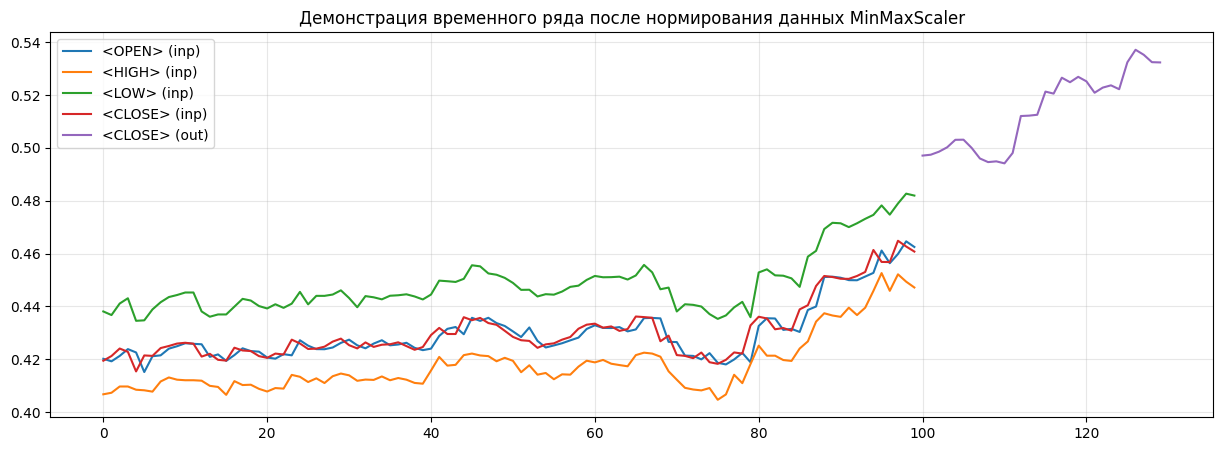

In [ ]:
# @title 2б. применяем скейлинг к полученным массивам (MinMaxScaler)

x_array_minmax = x_array.copy()
y_array_minmax = y_array.copy()
for i, col_name in enumerate(inputs):
    globals()[f"inp_scaler_{i}"] = MinMaxScaler()
    globals()[f"inp_scaler_{i}"].fit(x_array_minmax[:, :, i].reshape(-1, 1))
    orig_shape = x_array_minmax[:, :, i].shape
    transformed_arr = globals()[f"inp_scaler_{i}"].transform(x_array_minmax[:, :, i].reshape(-1, 1))
    x_array_minmax[:, :, i] = transformed_arr.reshape(orig_shape)
    print(f'Колонка "{col_name}": Min: {globals()[f"inp_scaler_{i}"].__dict__.get("data_min_")[0]}, Max: {globals()[f"inp_scaler_{i}"].__dict__.get("data_max_")[0]}')
print()
for i, col_name in enumerate(outputs):
    globals()[f"out_scaler_{i}"] = MinMaxScaler()
    globals()[f"out_scaler_{i}"].fit(y_array_minmax[:, :, i].reshape(-1, 1))
    orig_shape = y_array_minmax[:, :, i].shape
    transformed_arr = globals()[f"out_scaler_{i}"].transform(y_array_minmax[:, :, i].reshape(-1, 1))
    y_array_minmax[:, :, i] = transformed_arr.reshape(orig_shape)
    print(f'Колонка "{col_name}": Min: {globals()[f"out_scaler_{i}"].__dict__.get("data_min_")[0]}, Max: {globals()[f"out_scaler_{i}"].__dict__.get("data_max_")[0]}')

sample_idx = 100

plt.figure(figsize=(15, 5))
for i, col_name in enumerate(inputs):
    plt.plot(x_array_minmax[sample_idx, :, i], label=f"{col_name} (inp)")
for i, col_name in enumerate(outputs):
    plt.plot([None for _ in range(100)] + y_array_minmax[sample_idx, :, i].tolist(), label=f"{col_name} (out)")
plt.grid(True, alpha=0.3)
plt.title('Демонстрация временного ряда после нормирования данных MinMaxScaler')
plt.legend()
plt.show()

In [ ]:
# @title 3. разделить на train/test выборку.

x_train, x_test, y_train, y_test = train_test_split(x_array, y_array, train_size=0.7, shuffle=True)
print(f"Размерность обучающей выборки: X - {x_train.shape}, Y - {y_train.shape}")
print(f"Размерность тестовой выборки: X - {x_test.shape}, Y - {y_test.shape}")

Размерность обучающей выборки: X - (79, 100, 4), Y - (79, 30, 1)
Размерность тестовой выборки: X - (34, 100, 4), Y - (34, 30, 1)


In [ ]:
del x_train, y_test
del x_test, y_test

## Создание датасета с помощью Terra AI Datasets

Для создания датасета под задачу предсказания временных рядов создадим экземпляр класса **TimeseriesDepth** со следующими параметрами:

- csv_path - путь до csv-файла;
- train_size - размер обучающей выборки от 0 до 1;
- inputs - список колонок, используемых в качестве входа;
- outputs - список колонок, используемых в качестве выхода;
- preprocessing - Выбор скейлера. Варианты: "StandardScaler", "MinMaxScaler";
- length - длина одного примера;
- step - длина шага окна разбивки при составлении примеров;
- depth - глубина предсказания.

Кроме предсказания временных рядов можно создать датасет по предсказанию тренда временных рядов (вверх, вниз, нейтрально). Для этого необходимо создать экземпляр класса **TimeseriesTrend** со следующими параметрами:

- csv_path - путь до csv-файла;
- train_size - размер обучающей выборки от 0 до 1;
- inputs - список колонок, используемых в качестве входа;
- outputs - список колонок, используемых в качестве выхода;
preprocessing - Выбор скейлера. Варианты: "StandardScaler", "MinMaxScaler";
- length - длина одного примера;
- step - длина шага окна разбивки при составлении примеров;
- deviation - отклонение нулевого тренда в процентах;
- one_hot_encoding - перевод в формат One-Hot Encoding.

### Предсказание временных рядов

In [ ]:
ts_depth = TimeseriesDepth(
    csv_path='shares/YNDX_1d.csv',                    # Путь до .csv файла
    train_size=0.7,                                   # Размер тренировочной выборки - 70% от размера датасета
    inputs=["<OPEN>", "<HIGH>", "<LOW>", "<CLOSE>"],  # Список колонок, используемых в качестве входа
    outputs=["<CLOSE>"],                              # Список колонок, используемых в качестве выхода
    preprocessing="StandardScaler",                   # Скейлер (для каждой колонки создается свой скейлер)
    length=100,                                       # Количество строк (временных значений), используемый во входных массивах
    step=20,                                          # Шаг окна
    depth=30,                                         # Глубина предсказания
)

10:53:15 | Датасет подготовлен к началу формирования массивов
INFO:terra_ai_datasets.creation.utils:Датасет подготовлен к началу формирования массивов


In [ ]:
ts_depth.summary()

,1_<OPEN>,2_<HIGH>,3_<LOW>,4_<CLOSE>,5_<CLOSE>
0,1148.9,1157.9,1148.9,1150.8,1150.8
1,1150.0,1150.0,1132.8,1132.8,1132.8
2,1133.1,1133.1,1128.0,1128.2,1128.2
3,1129.7,1130.0,1129.7,1130.0,1130.0
4,1130.0,1131.9,1112.7,1112.9,1112.9



Кол-во примеров в train выборке: 7968
Кол-во примеров в val выборке: 3416



Метод .visualize() позволяет визуализировать данные в датасете. Его можно запустить как до метода .create(), так и после, с одной лишь разницей, что, при запуске до .create() не будут применены скейлеры (если были указаны при создании).

Ниже представлен график данных, на которых еще не повлиял StandardScaler, так как не был запущен процесс создания массивов и обучения скейлеров.

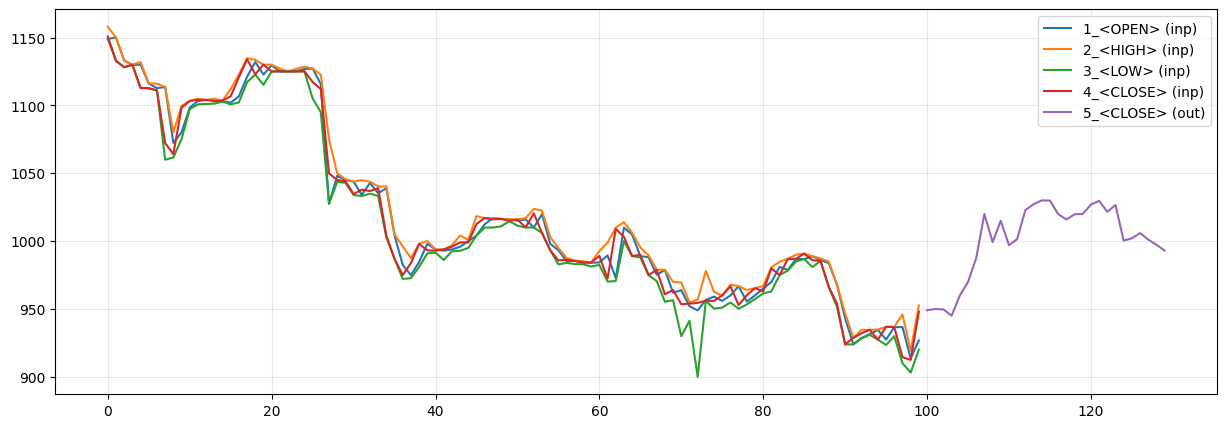

In [ ]:
ts_depth.visualize()

In [ ]:
ts_depth.create()

10:53:20 | Формирование массивов train - Timeseries - 1_<OPEN>: 100%|██████████| 389/389 [00:00<00:00, 1824.70it/s]
10:53:20 | Формирование массивов train - Timeseries - 2_<HIGH>: 100%|██████████| 389/389 [00:00<00:00, 1653.80it/s]
10:53:20 | Формирование массивов train - Timeseries - 3_<LOW>: 100%|██████████| 389/389 [00:00<00:00, 1812.64it/s]
10:53:20 | Формирование массивов train - Timeseries - 4_<CLOSE>: 100%|██████████| 389/389 [00:00<00:00, 1761.03it/s]
10:53:21 | Формирование массивов train - Depth - 5_<CLOSE>: 100%|██████████| 389/389 [00:00<00:00, 1654.69it/s]
10:53:21 | Формирование массивов val - Timeseries - 1_<OPEN>: 100%|██████████| 161/161 [00:00<00:00, 9754.48it/s]
10:53:21 | Формирование массивов val - Timeseries - 2_<HIGH>: 100%|██████████| 161/161 [00:00<00:00, 11112.66it/s]
10:53:21 | Формирование массивов val - Timeseries - 3_<LOW>: 100%|██████████| 161/161 [00:00<00:00, 10370.62it/s]
10:53:21 | Формирование массивов val - Timeseries - 4_<CLOSE>: 100%|██████████| 1

Снова вызовем метод .visualize() и посмотрим как выглядят отнормированные данные.

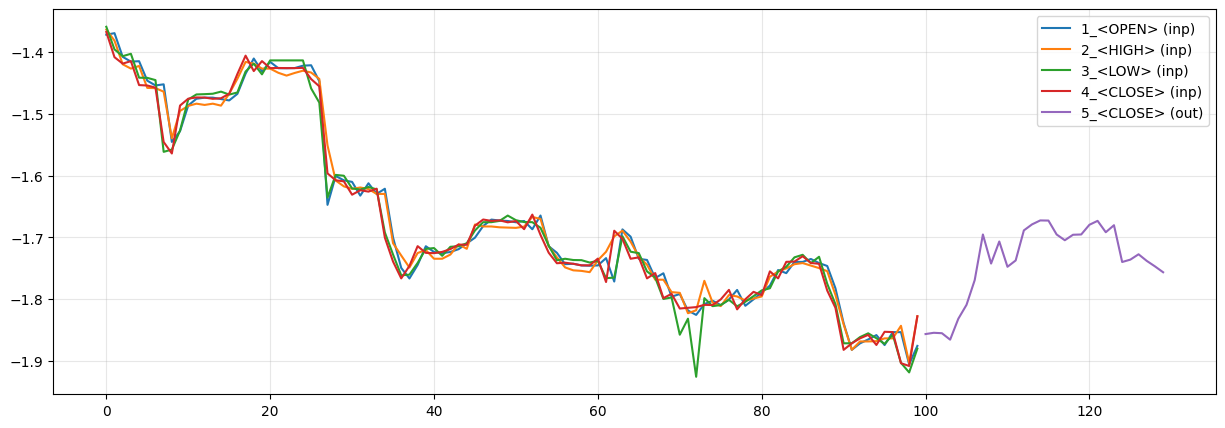

In [ ]:
ts_depth.visualize()

Задача данной нейросети - исходя из 100 временных значений колонок OPEN, HIGH, LOW, CLOSE предсказать следующие 30 значений для колонки CLOSE.

Ниже приведена визуализация временного ряда для четырех колонок с визуализацией значения одной колонки, которую необходимо предсказать.

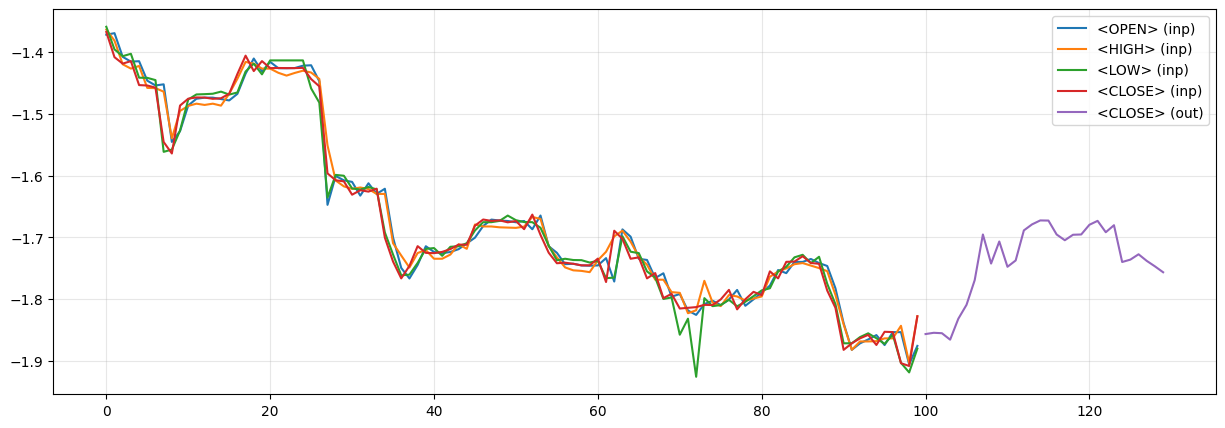

In [ ]:
# Данные первого примера для обучения НС
plot_ts_depth_graph(ts_depth, 0)

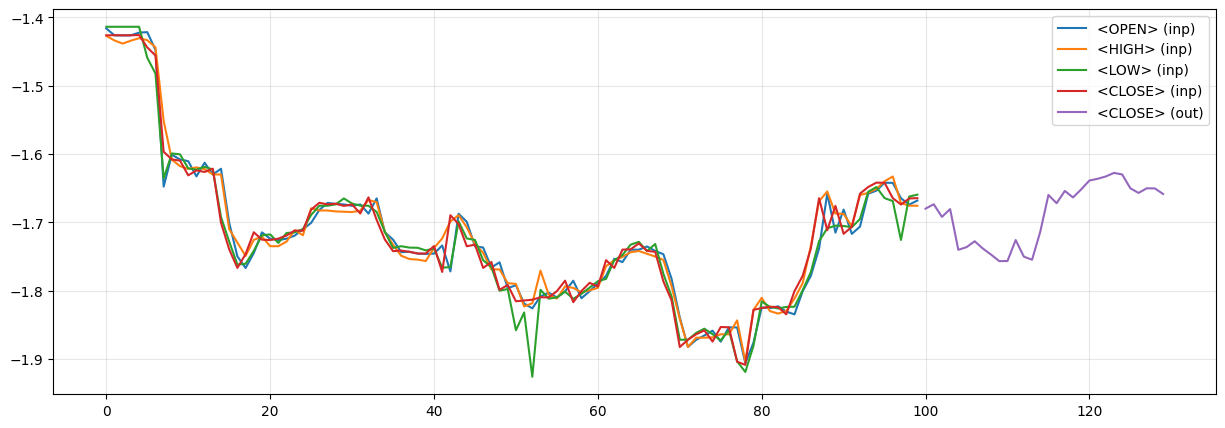

In [ ]:
# Данные второго примера для обучения НС. Видно смещение (step=20) на 20 единиц по сравнению с верхним графиком.
plot_ts_depth_graph(ts_depth, 1)

In [ ]:
model = Sequential()
model.add(Input((100, 4), name="input_1"))
model.add(Conv1D(200, 4, activation="linear"))
model.add(Conv1D(200, 4, activation="linear"))
model.add(Flatten())
model.add(Dense(100, activation="linear"))
model.add(Dense(30, activation="linear", name="output_1"))
model.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))

In [ ]:
model.fit(ts_depth.dataset['train'].batch(32), epochs=10, validation_data=ts_depth.dataset['val'].batch(32), verbose=1)

Epoch 1/10
13/13 [==============================] - 3s 32ms/step - loss: 0.4058 - val_loss: 1.1854
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 0.0906 - val_loss: 0.3142
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 0.0532 - val_loss: 0.3225
Epoch 4/10
13/13 [==============================] - 0s 16ms/step - loss: 0.0480 - val_loss: 0.3467
Epoch 5/10
13/13 [==============================] - 0s 16ms/step - loss: 0.0414 - val_loss: 0.2538
Epoch 6/10
13/13 [==============================] - 0s 16ms/step - loss: 0.0385 - val_loss: 0.2498
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 0.0366 - val_loss: 0.2162
Epoch 8/10
13/13 [==============================] - 0s 14ms/step - loss: 0.0358 - val_loss: 0.2277
Epoch 9/10
13/13 [==============================] - 0s 10ms/step - loss: 0.0354 - val_loss: 0.2153
Epoch 10/10
13/13 [==============================] - 0s 13ms/step - loss: 0.0348 - val_loss: 0.2215


1/1 [==============================] - 0s 65ms/step


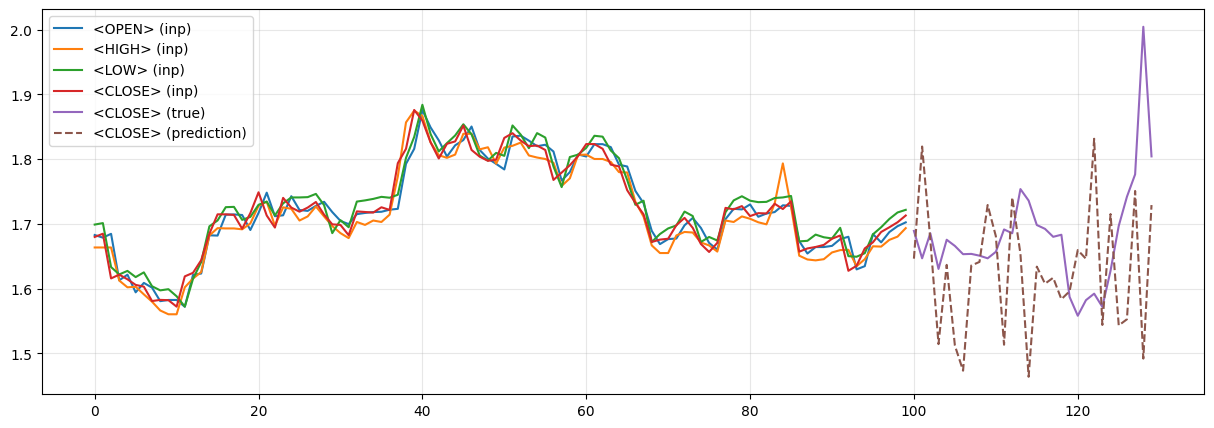

In [ ]:
visualize_ts_depth_prediction(ts_depth, model)

### Предсказание тренда временных рядов

In [ ]:
ts_trend = TimeseriesTrend(
    csv_path='shares/YNDX_1d.csv',                    # Путь до .csv файла
    train_size=0.7,                                   # Размер тренировочной выборки - 70% от размера датасета
    inputs=["<OPEN>", "<HIGH>", "<LOW>", "<CLOSE>"],  # Список колонок, используемых в качестве входа
    output="<CLOSE>",                                 # Для предсказания тренда в output допускается только одна колонка
    preprocessing="StandardScaler",                   # Скейлер (для каждой колонки создается свой скейлер)
    length=100,                                       # Количество строк (временных значений), используемый во входных массивах
    step=20,                                          # Шаг окна 
    deviation=0.5,                                    # Отклонение нулевого тренда в процентах
    one_hot_encoding=True                             # Перевод в формат One-Hot Encoding
)

10:56:46 | Датасет подготовлен к началу формирования массивов
INFO:terra_ai_datasets.creation.utils:Датасет подготовлен к началу формирования массивов


In [ ]:
ts_trend.summary()

,1_<OPEN>,2_<HIGH>,3_<LOW>,4_<CLOSE>,5_<CLOSE>
0,1148.9,1157.9,1148.9,1150.8,1150.8
1,1150.0,1150.0,1132.8,1132.8,1132.8
2,1133.1,1133.1,1128.0,1128.2,1128.2
3,1129.7,1130.0,1129.7,1130.0,1130.0
4,1130.0,1131.9,1112.7,1112.9,1112.9



Кол-во примеров в train выборке: 7968
Кол-во примеров в val выборке: 3416



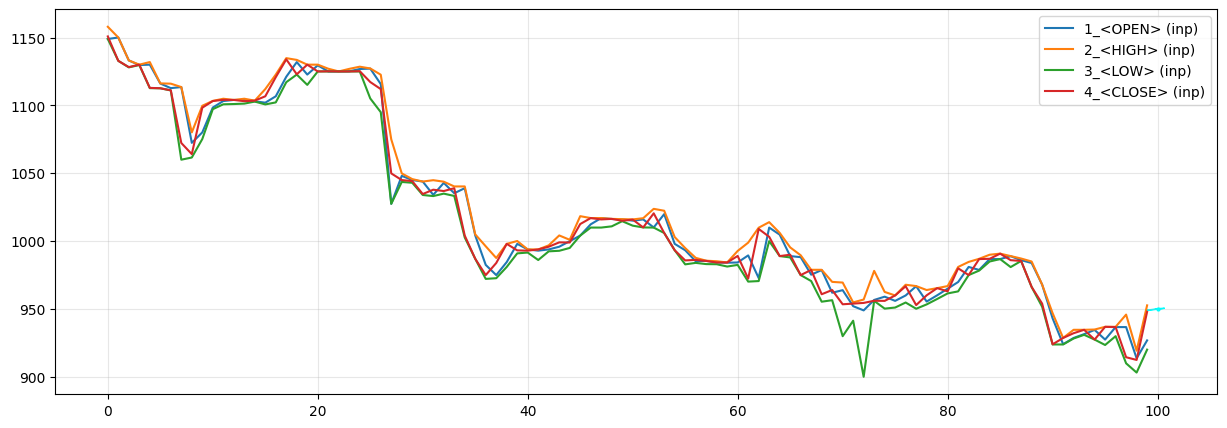

In [ ]:
ts_trend.visualize()

In [ ]:
ts_trend.create()

10:56:52 | Формирование массивов train - Timeseries - 1_<OPEN>: 100%|██████████| 389/389 [00:00<00:00, 1749.74it/s]
10:56:52 | Формирование массивов train - Timeseries - 2_<HIGH>: 100%|██████████| 389/389 [00:00<00:00, 1887.12it/s]
10:56:52 | Формирование массивов train - Timeseries - 3_<LOW>: 100%|██████████| 389/389 [00:00<00:00, 1916.60it/s]
10:56:52 | Формирование массивов train - Timeseries - 4_<CLOSE>: 100%|██████████| 389/389 [00:00<00:00, 1724.00it/s]
10:56:53 | Формирование массивов train - Trend - 5_<CLOSE>: 100%|██████████| 389/389 [00:00<00:00, 7720.70it/s]
10:56:53 | Формирование массивов val - Timeseries - 1_<OPEN>: 100%|██████████| 161/161 [00:00<00:00, 10813.70it/s]
10:56:53 | Формирование массивов val - Timeseries - 2_<HIGH>: 100%|██████████| 161/161 [00:00<00:00, 10216.70it/s]
10:56:53 | Формирование массивов val - Timeseries - 3_<LOW>: 100%|██████████| 161/161 [00:00<00:00, 8236.26it/s]
10:56:53 | Формирование массивов val - Timeseries - 4_<CLOSE>: 100%|██████████| 1

Задача данной нейросети - исходя из 100 временных значений колонок OPEN, HIGH, LOW, CLOSE предсказать, пойдет ли следующее значение колонки CLOSE вверх, вниз, или не изменится.

Ниже приведена визуализация временного ряда для четырех колонок с визуализацией. Видно, что значение колонки Close на следующем этапе находится в диапазоне 0.5% (deviation=0.5), поэтому в данном случае нейросеть должна обозначить ее как "тренд не изменился".

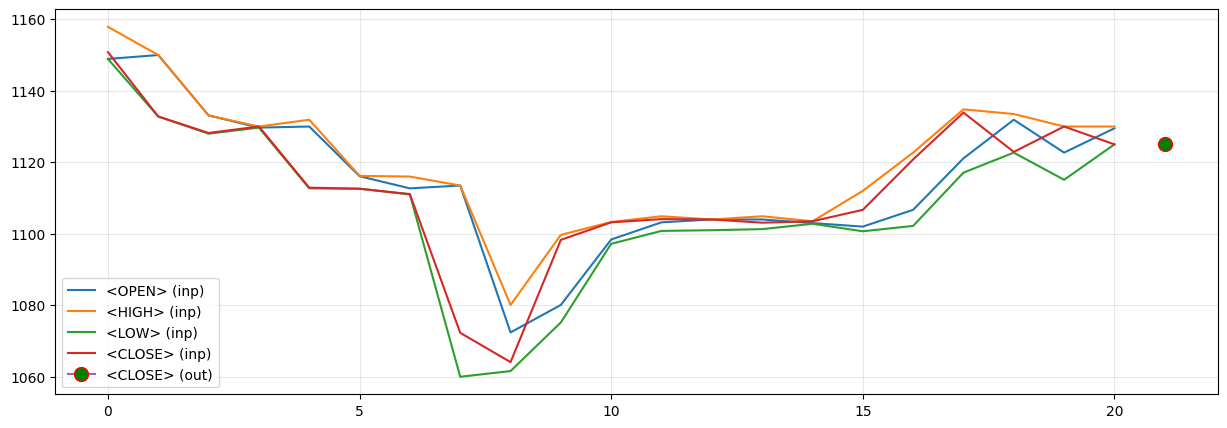

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(ts_trend.dataframe['train'].loc[:20, '1_<OPEN>'], label="<OPEN> (inp)")
plt.plot(ts_trend.dataframe['train'].loc[:20, '2_<HIGH>'], label="<HIGH> (inp)")
plt.plot(ts_trend.dataframe['train'].loc[:20, '3_<LOW>'], label="<LOW> (inp)")
plt.plot(ts_trend.dataframe['train'].loc[:20, '4_<CLOSE>'], label="<CLOSE> (inp)")
plt.plot([None for _ in range(21)] + [ts_trend.dataframe['train'].loc[21, '5_<CLOSE>']], label="<CLOSE> (out)", marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.grid(True, alpha=0.3)
plt.legend()

In [ ]:
model = Sequential()
model.add(Input((100, 4), name="input_1"))
model.add(Conv1D(200, 4, activation="linear"))
model.add(Conv1D(200, 4, activation="linear"))
model.add(Flatten())
model.add(Dense(100, activation="linear"))
model.add(Dense(3, activation="softmax", name="output_1"))  # Три нейрона, т.к. решаем задачу классификации на 3 класса - 'Не изменился', 'Вверх', 'Вниз'.
model.compile(loss="mse", optimizer=Adam(learning_rate=1e-4), metrics="accuracy")

In [ ]:
model.fit(ts_trend.dataset['train'].batch(32), epochs=10, validation_data=ts_trend.dataset['val'].batch(32), verbose=1)

Epoch 1/10
13/13 [==============================] - 2s 18ms/step - loss: 0.3564 - accuracy: 0.3496 - val_loss: 0.5519 - val_accuracy: 0.1677
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 0.3756 - accuracy: 0.3702 - val_loss: 0.4940 - val_accuracy: 0.1429
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 0.3151 - accuracy: 0.3933 - val_loss: 0.3973 - val_accuracy: 0.1925
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 0.3005 - accuracy: 0.3959 - val_loss: 0.1666 - val_accuracy: 0.6894
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 0.1967 - accuracy: 0.5835 - val_loss: 0.2069 - val_accuracy: 0.6894
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 0.2850 - accuracy: 0.4524 - val_loss: 0.2070 - val_accuracy: 0.6894
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 0.2952 - accuracy: 0.4524 - val_loss: 0.2070 - val_accuracy: 0.6894
Epoch 8/10
13/13 [=

In [ ]:
visualize_ts_trend_prediction(ts_trend, model)

1/1 [==============================] - 0s 34ms/step
Истина: Вверх, Предсказание: Вниз
Истина: Не изменился, Предсказание: Вниз
Истина: Не изменился, Предсказание: Вниз
Истина: Не изменился, Предсказание: Вниз
Истина: Не изменился, Предсказание: Вниз
Истина: Вверх, Предсказание: Вниз
Истина: Не изменился, Предсказание: Вниз
Истина: Вверх, Предсказание: Вниз
Истина: Не изменился, Предсказание: Вниз
Истина: Вверх, Предсказание: Вниз
